In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mplsoccer.heatmap import bin_statistic, heatmap
from dataclasses import dataclass
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# load on target shots
df_wyscout = pd.read_parquet(os.path.join('..', '..', 'data', 'wyscout', 'event.parquet'))
df_shot = df_wyscout[df_wyscout.eventName == 'Shot'].copy()
df_shot_on_target = df_shot[df_shot.position.str[:4] == 'goal'].copy()
# number of bins for heatmap
BINS = 3
cmap = LinearSegmentedColormap.from_list('my cmap', ['#15242e', '#4393c4'], N=10)

In [3]:
# mplsoccer heatmap requires that you pass the dimensions so we are going
# to create some simple goal dimensions
@dataclass
class GoalDims:
    left: float = 0
    right: float = 7.32
    bottom: float = 0
    top: float = 2.44
    invert_y: bool = False
goal_dims = GoalDims()

In [4]:
# we want to split the goal into three * three segments, but wyscout has text descriptions
# so we map the text descriptions to centers of the three by three segments
stats = bin_statistic(0, 0, bins=(BINS, BINS), dim=goal_dims)  # easy way to get heatmap centers for mappings
cx = stats['cx'].ravel()
cy = stats['cy'].ravel()
labels = ['goal low left', 'goal low center', 'goal low right',
          'goal center left', 'goal center', 'goal center right',
          'goal high left' , 'goal high center','goal high right']

cx_map = dict(zip(labels, cx))
cy_map = dict(zip(labels, cy))

df_shot_on_target['position_x']  = df_shot_on_target.position.map(cx_map)
df_shot_on_target['position_y']  = df_shot_on_target.position.map(cy_map)

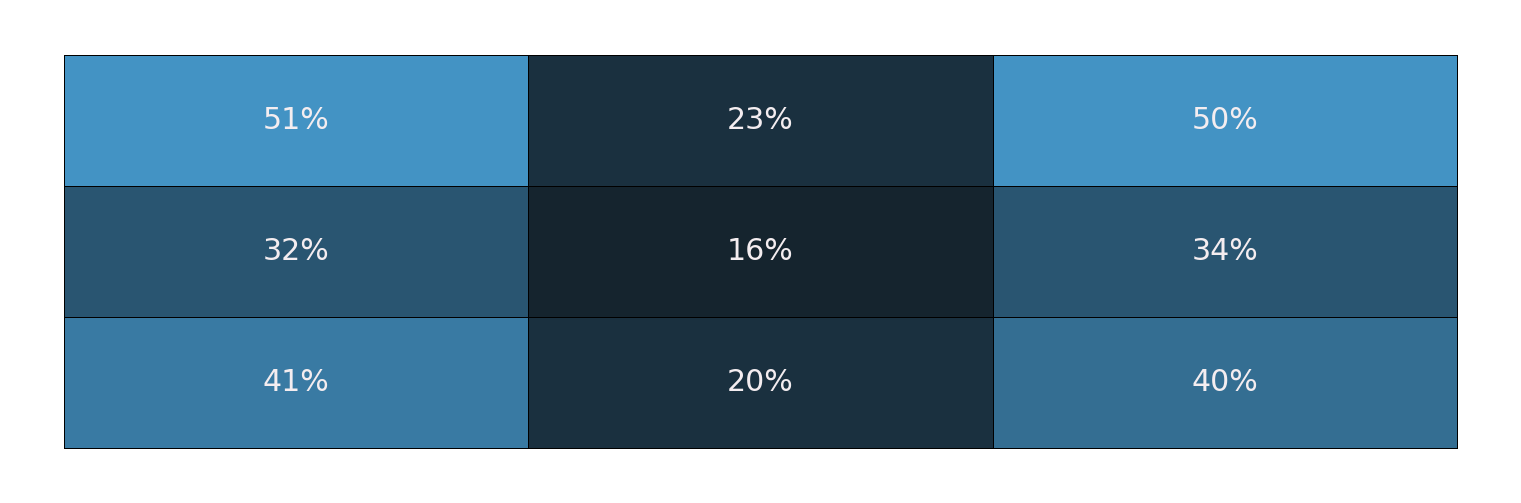

In [5]:
# set figure size
FIGHEIGHT = 9
PAD = 0.3
FIGWIDTH = FIGHEIGHT / (goal_dims.top / goal_dims.right)

# plot the goal heatmap
fig, ax = plt.subplots(figsize=(FIGWIDTH, FIGHEIGHT))
ax.set_xlim(goal_dims.left - PAD, goal_dims.right + PAD)
ax.set_ylim(goal_dims.bottom - PAD, goal_dims.top + PAD)
stats = bin_statistic(df_shot_on_target['position_x'], df_shot_on_target['position_y'],
                      values=df_shot_on_target.goal, statistic='mean',
                      dim=goal_dims, bins=(BINS, BINS))
heatmap(stats, ax=ax, cmap=cmap, edgecolor='black')
ax.axis('off')

# annotate
cx = np.ravel(stats['cx'])
cy = np.ravel(stats['cy'])
text = np.ravel(stats['statistic'])
for idx, text_str in enumerate(text):
    text_str = '{:.0%}'.format(text_str)
    ax.text(cx[idx], cy[idx], text_str, color='#f4edf0', fontsize=30, va='center', ha='center')
fig.savefig('heatmap1.png')

In [6]:
# number of shots/ goals in each bin
stats_goals = bin_statistic(df_shot_on_target.loc[df_shot_on_target.goal, ['position_x']],
                            df_shot_on_target.loc[df_shot_on_target.goal, ['position_y']],
                            dim=goal_dims, bins=(BINS, BINS))
stats_shots = bin_statistic(df_shot_on_target['position_x'],
                            df_shot_on_target['position_y'],
                            dim=goal_dims, bins=(BINS, BINS))
stats_shots = stats_shots['statistic'].ravel()
stats_goals = stats_goals['statistic'].ravel()

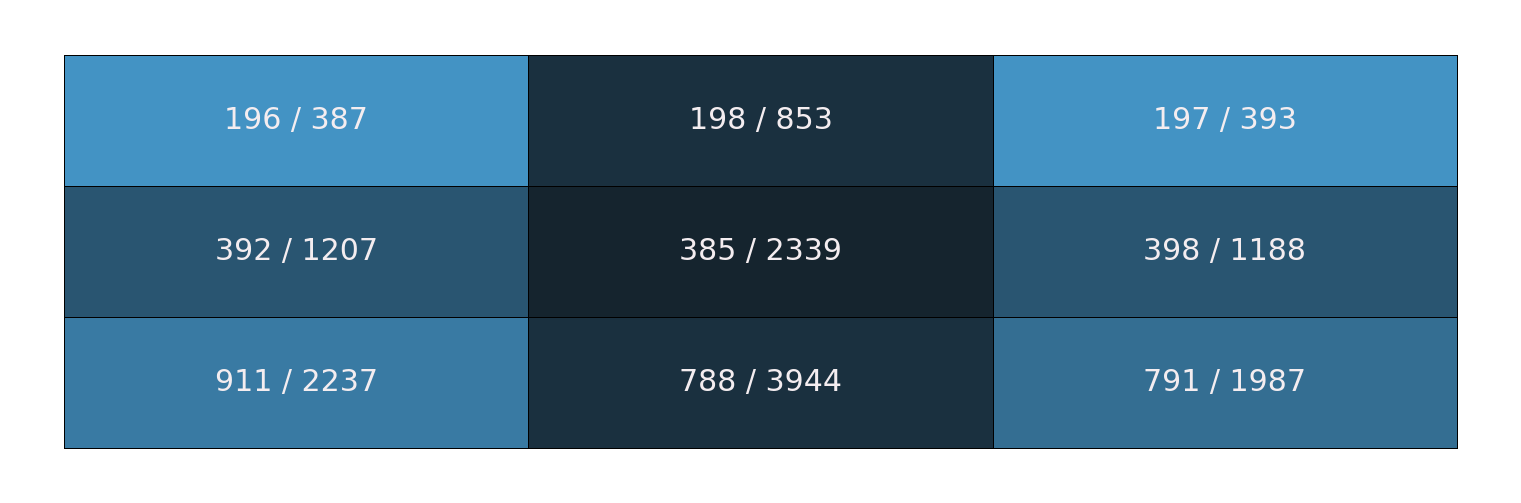

In [7]:
# plot the goal heatmap
fig, ax = plt.subplots(figsize=(FIGWIDTH, FIGHEIGHT))
ax.set_xlim(goal_dims.left - PAD, goal_dims.right + PAD)
ax.set_ylim(goal_dims.bottom - PAD, goal_dims.top + PAD)
heatmap(stats, ax=ax, cmap=cmap, edgecolor='black')
ax.axis('off')

# annotate
for idx, text_str in enumerate(cx):
    text_str = f'{int(stats_goals[idx])} / {int(stats_shots[idx])}'
    ax.text(cx[idx], cy[idx], text_str, fontsize=30, color='#f4edf0', va='center', ha='center')
fig.savefig('heatmap2.png')